# Clasificador de Imágenes con Autoencoder CNN - Versión Mejorada

## Mejoras implementadas:
- ✅ Corrección de bug dimensional en el clasificador
- ✅ Data augmentation para mejor generalización
- ✅ Validación durante entrenamiento (train/val/test split)
- ✅ Early stopping para evitar overfitting
- ✅ Batch normalization
- ✅ Learning rate scheduler
- ✅ Visualización de métricas en tiempo real
- ✅ Sistema robusto de guardado/carga de modelos
- ✅ Listo para inferencia en imágenes nuevas

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from datetime import datetime
import copy

In [2]:
# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Semilla para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)

Usando dispositivo: cuda


## 1. Configuración de hiperparámetros

In [3]:
# Configuración
CONFIG = {
    # Datos
    'data_dir': 'objetos_salon/processed',
    'batch_size': 64,
    'train_split': 0.7,
    'val_split': 0.15,
    'test_split': 0.15,
    'img_size': 32,
    'num_workers': 2,
    
    # Autoencoder
    'latent_dim': 128,
    'ae_epochs': 30,
    'ae_lr': 1e-3,
    'ae_patience': 5,
    
    # Classifier
    'classifier_epochs': 25,
    'classifier_lr': 1e-3,
    'classifier_patience': 7,
    'dropout': 0.5,
    
    # Output
    'export_dir': 'export_v4',
    'save_best_only': True
}

print("Configuración:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuración:
  data_dir: objetos_salon/processed
  batch_size: 64
  train_split: 0.7
  val_split: 0.15
  test_split: 0.15
  img_size: 32
  num_workers: 2
  latent_dim: 128
  ae_epochs: 30
  ae_lr: 0.001
  ae_patience: 5
  classifier_epochs: 25
  classifier_lr: 0.001
  classifier_patience: 7
  dropout: 0.5
  export_dir: export_v4
  save_best_only: True


## 2. Preparación de datos con augmentation

In [4]:
def get_data_loaders(config):
    """
    Crea DataLoaders con train/val/test split y data augmentation.
    """
    img_size = config['img_size']
    
    # Transformaciones para entrenamiento (con augmentation)
    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    # Transformaciones para validación/test (sin augmentation)
    eval_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    # Cargar dataset completo
    full_dataset = datasets.ImageFolder(root=config['data_dir'], transform=eval_transform)
    classes = full_dataset.classes
    
    print(f"\nClases encontradas: {classes}")
    print(f"Total de imágenes: {len(full_dataset)}")
    
    # Dividir en train/val/test
    total_size = len(full_dataset)
    train_size = int(config['train_split'] * total_size)
    val_size = int(config['val_split'] * total_size)
    test_size = total_size - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    # Aplicar transformaciones de augmentation solo al train set
    train_dataset.dataset = copy.deepcopy(full_dataset)
    train_dataset.dataset.transform = train_transform
    
    print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")
    
    # Crear DataLoaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=config['batch_size'], 
        shuffle=True, 
        num_workers=config['num_workers']
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=config['batch_size'], 
        shuffle=False, 
        num_workers=config['num_workers']
    )
    test_loader = DataLoader(
        test_dataset, 
        batch_size=config['batch_size'], 
        shuffle=False, 
        num_workers=config['num_workers']
    )
    
    return train_loader, val_loader, test_loader, classes

In [5]:
# Cargar datos
train_loader, val_loader, test_loader, classes = get_data_loaders(CONFIG)
num_classes = len(classes)


Clases encontradas: ['cpu', 'mesa', 'mouse', 'nada', 'pantalla', 'silla', 'teclado']
Total de imágenes: 1619
Train: 1133 | Val: 242 | Test: 244


## 3. Arquitectura mejorada del Autoencoder

In [6]:
class ImprovedAutoencoder(nn.Module):
    """
    Autoencoder Convolucional mejorado con Batch Normalization.
    """
    def __init__(self, latent_dim=128):
        super(ImprovedAutoencoder, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder con Batch Normalization
        self.encoder = nn.Sequential(
            # Input: 3 x 32 x 32
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 16 x 16 x 16
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 32 x 8 x 8
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)   # -> 64 x 4 x 4 = 1024
        )
        
        # Bottleneck: 1024 -> latent_dim
        self.to_latent = nn.Sequential(
            nn.Linear(64 * 4 * 4, latent_dim),
            nn.ReLU()
        )
        
        # Expand: latent_dim -> 1024
        self.from_latent = nn.Sequential(
            nn.Linear(latent_dim, 64 * 4 * 4),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # -> 32 x 8 x 8
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),  # -> 16 x 16 x 16
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2),   # -> 3 x 32 x 32
            nn.Tanh()
        )

    def forward(self, x):
        # Encode
        encoded = self.encoder(x)
        encoded = encoded.view(encoded.size(0), -1)
        latent_code = self.to_latent(encoded)
        
        # Decode
        decoded = self.from_latent(latent_code)
        decoded = decoded.view(decoded.size(0), 64, 4, 4)
        reconstructed = self.decoder(decoded)
        
        return reconstructed, latent_code
    
    def encode(self, x):
        """Método auxiliar para extraer solo el latent code."""
        encoded = self.encoder(x)
        encoded = encoded.view(encoded.size(0), -1)
        latent_code = self.to_latent(encoded)
        return latent_code

# Crear modelo
autoencoder = ImprovedAutoencoder(latent_dim=CONFIG['latent_dim'])
print(f"\nAutoencoder creado con latent_dim={CONFIG['latent_dim']}")
print(f"Parámetros totales: {sum(p.numel() for p in autoencoder.parameters()):,}")


Autoencoder creado con latent_dim=128
Parámetros totales: 297,683


## 4. Entrenamiento del Autoencoder con validación

In [9]:
class EarlyStopping:
    """
    Early stopping para detener el entrenamiento si no hay mejora.
    """
    def __init__(self, patience=7, min_delta=0, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_state = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model_state = copy.deepcopy(model.state_dict())
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'  EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model_state = copy.deepcopy(model.state_dict())
            self.counter = 0
            if self.verbose:
                print(f'  Validación mejoró a {val_loss:.4f}')


def train_autoencoder(model, train_loader, val_loader, config):
    """
    Entrena el autoencoder con validación y early stopping.
    """
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config['ae_lr'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )
    early_stopping = EarlyStopping(patience=config['ae_patience'])
    
    history = {'train_loss': [], 'val_loss': []}
    
    print("\n" + "="*60)
    print("ENTRENAMIENTO DEL AUTOENCODER")
    print("="*60)
    
    for epoch in range(config['ae_epochs']):
        # Entrenamiento
        model.train()
        train_loss = 0.0
        for images, _ in train_loader:
            images = images.to(device)
            
            optimizer.zero_grad()
            reconstructed, _ = model(images)
            loss = criterion(reconstructed, images)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Validación
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(device)
                reconstructed, _ = model(images)
                loss = criterion(reconstructed, images)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        print(f'Epoch [{epoch+1}/{config["ae_epochs"]}] '
              f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f"\nEarly stopping en epoch {epoch+1}")
            model.load_state_dict(early_stopping.best_model_state)
            break
    
    # Cargar el mejor modelo
    if early_stopping.best_model_state is not None:
        model.load_state_dict(early_stopping.best_model_state)
    
    print("\n" + "="*60)
    print("ENTRENAMIENTO DEL AUTOENCODER COMPLETADO")
    print("="*60)
    
    return history

In [10]:
# Entrenar autoencoder
ae_history = train_autoencoder(autoencoder, train_loader, val_loader, CONFIG)


ENTRENAMIENTO DEL AUTOENCODER
Epoch [1/30] Train Loss: 0.3380 | Val Loss: 0.2520
Epoch [2/30] Train Loss: 0.2826 | Val Loss: 0.2467
  Validación mejoró a 0.2467
Epoch [3/30] Train Loss: 0.2562 | Val Loss: 0.2491
  EarlyStopping counter: 1/5
Epoch [4/30] Train Loss: 0.2010 | Val Loss: 0.1826
  Validación mejoró a 0.1826
Epoch [5/30] Train Loss: 0.1579 | Val Loss: 0.1260
  Validación mejoró a 0.1260
Epoch [6/30] Train Loss: 0.1284 | Val Loss: 0.1090
  Validación mejoró a 0.1090
Epoch [7/30] Train Loss: 0.1128 | Val Loss: 0.0950
  Validación mejoró a 0.0950
Epoch [8/30] Train Loss: 0.1030 | Val Loss: 0.0884
  Validación mejoró a 0.0884
Epoch [9/30] Train Loss: 0.0944 | Val Loss: 0.0792
  Validación mejoró a 0.0792
Epoch [10/30] Train Loss: 0.0863 | Val Loss: 0.0735
  Validación mejoró a 0.0735
Epoch [11/30] Train Loss: 0.0825 | Val Loss: 0.0703
  Validación mejoró a 0.0703
Epoch [12/30] Train Loss: 0.0776 | Val Loss: 0.0683
  Validación mejoró a 0.0683
Epoch [13/30] Train Loss: 0.0753 | 

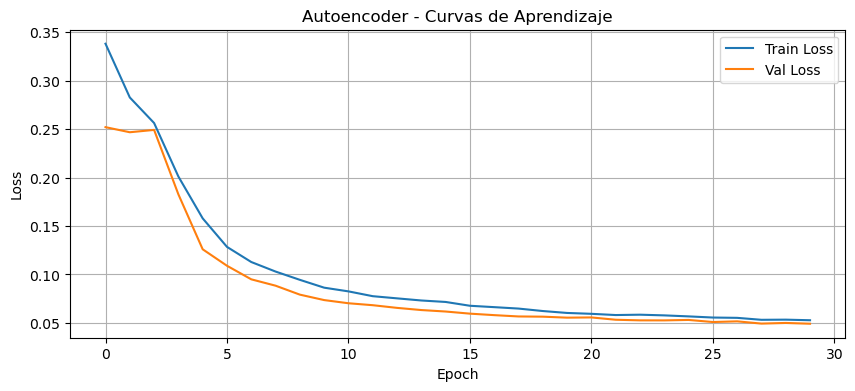

In [11]:
# Visualizar curvas de aprendizaje
plt.figure(figsize=(10, 4))
plt.plot(ae_history['train_loss'], label='Train Loss')
plt.plot(ae_history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Autoencoder - Curvas de Aprendizaje')
plt.legend()
plt.grid(True)
plt.show()

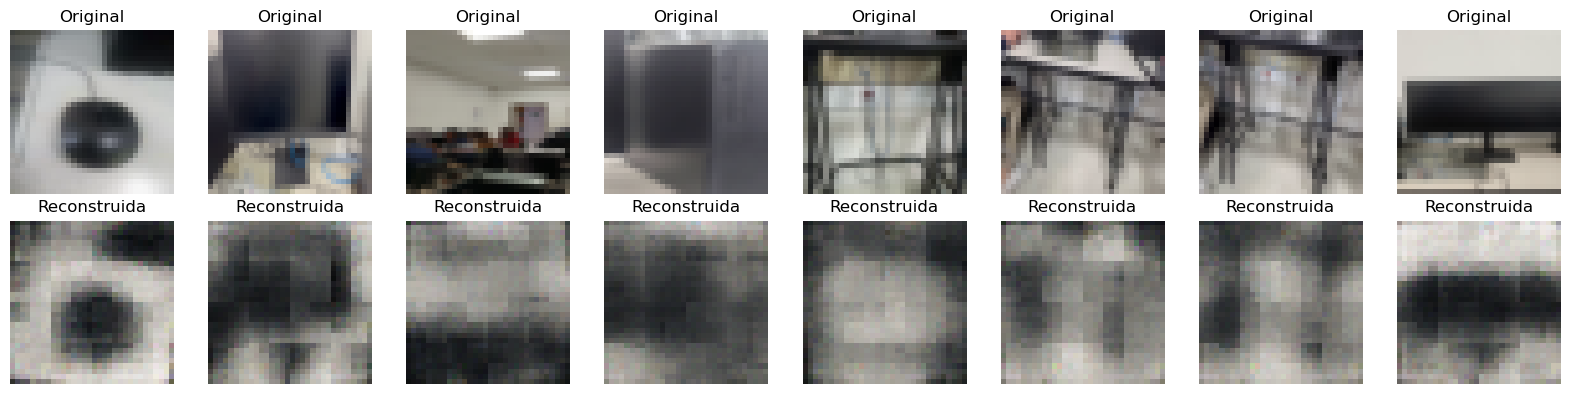

In [12]:
# Visualizar reconstrucciones
def imshow(img, title=""):
    """Desnormalizar y mostrar imagen."""
    img = img / 2 + 0.5
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

autoencoder.eval()
dataiter = iter(test_loader)
images, labels = next(dataiter)
images_gpu = images.to(device)

with torch.no_grad():
    reconstructed, _ = autoencoder(images_gpu)

# Mostrar originales vs reconstruidas
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    axes[0, i].imshow(np.transpose((images[i]/2 + 0.5).numpy(), (1, 2, 0)))
    axes[0, i].set_title('Original')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(np.transpose((reconstructed[i].cpu()/2 + 0.5).numpy(), (1, 2, 0)))
    axes[1, i].set_title('Reconstruida')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## 5. Clasificador mejorado (BUG CORREGIDO)

In [14]:
class ImprovedClassifier(nn.Module):
    """
    Clasificador que usa el autoencoder pre-entrenado.
    CORRECCIÓN: Usa correctamente el latent_code del autoencoder.
    """
    def __init__(self, autoencoder, num_classes, dropout=0.5, freeze_encoder=True):
        super(ImprovedClassifier, self).__init__()
        self.autoencoder = autoencoder
        self.latent_dim = autoencoder.latent_dim
        
        # Congelar autoencoder si se requiere
        if freeze_encoder:
            for param in self.autoencoder.parameters():
                param.requires_grad = False
        
        # Capas de clasificación
        self.classifier = nn.Sequential(
            nn.Linear(self.latent_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        # Extraer latent code del autoencoder (CORRECCIÓN CRÍTICA)
        with torch.no_grad():
            latent_code = self.autoencoder.encode(x)
        
        # Clasificar
        output = self.classifier(latent_code)
        return output

# Crear clasificador
classifier = ImprovedClassifier(
    autoencoder=autoencoder,
    num_classes=num_classes,
    dropout=CONFIG['dropout']
)

print(f"\nClasificador creado")
print(f"Entrada: {CONFIG['latent_dim']} (latent dim)")
print(f"Salida: {num_classes} clases")
print(f"Parámetros entrenables: {sum(p.numel() for p in classifier.parameters() if p.requires_grad):,}")


Clasificador creado
Entrada: 128 (latent dim)
Salida: 7 clases
Parámetros entrenables: 66,823


## 6. Entrenamiento del clasificador

In [15]:
def train_classifier(model, train_loader, val_loader, config):
    """
    Entrena el clasificador con validación y early stopping.
    """
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=config['classifier_lr'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3
    )
    
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0
    
    print("\n" + "="*60)
    print("ENTRENAMIENTO DEL CLASIFICADOR")
    print("="*60)
    
    for epoch in range(config['classifier_epochs']):
        # Entrenamiento
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        train_loss /= len(train_loader)
        train_acc = 100 * train_correct / train_total
        
        # Validación
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / val_total
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f'Epoch [{epoch+1}/{config["classifier_epochs"]}] '
              f'Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | '
              f'Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%')
        
        # Learning rate scheduling
        scheduler.step(val_acc)
        
        # Early stopping basado en accuracy de validación
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
            print(f'  Mejor modelo guardado (Val Acc: {val_acc:.2f}%)')
        else:
            patience_counter += 1
            print(f'  Paciencia: {patience_counter}/{config["classifier_patience"]}')
            
            if patience_counter >= config['classifier_patience']:
                print(f"\nEarly stopping en epoch {epoch+1}")
                break
    
    # Cargar el mejor modelo
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    print("\n" + "="*60)
    print(f"ENTRENAMIENTO COMPLETADO - Mejor Val Acc: {best_val_acc:.2f}%")
    print("="*60)
    
    return history

In [16]:
# Entrenar clasificador
clf_history = train_classifier(classifier, train_loader, val_loader, CONFIG)


ENTRENAMIENTO DEL CLASIFICADOR
Epoch [1/25] Train Loss: 1.9116 Acc: 21.71% | Val Loss: 1.7799 Acc: 34.30%
  Mejor modelo guardado (Val Acc: 34.30%)
Epoch [2/25] Train Loss: 1.7657 Acc: 30.19% | Val Loss: 1.6028 Acc: 48.76%
  Mejor modelo guardado (Val Acc: 48.76%)
Epoch [3/25] Train Loss: 1.6161 Acc: 40.34% | Val Loss: 1.4160 Acc: 56.61%
  Mejor modelo guardado (Val Acc: 56.61%)
Epoch [4/25] Train Loss: 1.5171 Acc: 45.01% | Val Loss: 1.3150 Acc: 59.92%
  Mejor modelo guardado (Val Acc: 59.92%)
Epoch [5/25] Train Loss: 1.4107 Acc: 49.16% | Val Loss: 1.2639 Acc: 60.33%
  Mejor modelo guardado (Val Acc: 60.33%)
Epoch [6/25] Train Loss: 1.3652 Acc: 53.49% | Val Loss: 1.2004 Acc: 61.57%
  Mejor modelo guardado (Val Acc: 61.57%)
Epoch [7/25] Train Loss: 1.2810 Acc: 54.99% | Val Loss: 1.1246 Acc: 64.88%
  Mejor modelo guardado (Val Acc: 64.88%)
Epoch [8/25] Train Loss: 1.2550 Acc: 57.28% | Val Loss: 1.0802 Acc: 62.40%
  Paciencia: 1/7
Epoch [9/25] Train Loss: 1.2363 Acc: 56.66% | Val Loss: 1

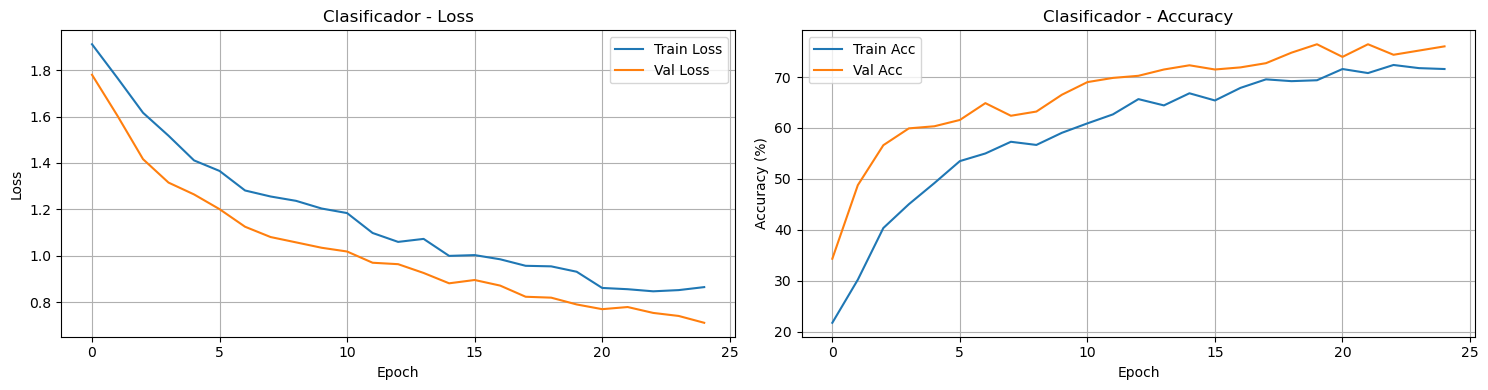

In [17]:
# Visualizar curvas de aprendizaje
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

# Loss
ax1.plot(clf_history['train_loss'], label='Train Loss')
ax1.plot(clf_history['val_loss'], label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Clasificador - Loss')
ax1.legend()
ax1.grid(True)

# Accuracy
ax2.plot(clf_history['train_acc'], label='Train Acc')
ax2.plot(clf_history['val_acc'], label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Clasificador - Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 7. Evaluación en test set

In [18]:
def evaluate_classifier(model, test_loader, classes):
    """
    Evalúa el clasificador en el test set.
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    print("\n" + "="*60)
    print("EVALUACIÓN EN TEST SET")
    print("="*60)
    
    with torch.no_grad():
        correct = 0
        total = 0
        
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    accuracy = 100 * correct / total
    print(f'\nTest Accuracy: {accuracy:.2f}%')
    
    # Classification report
    print("\nReporte de Clasificación:")
    print(classification_report(all_labels, all_preds, target_names=classes, digits=3))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta Real')
    plt.title('Matriz de Confusión - Test Set')
    plt.tight_layout()
    plt.show()
    
    return accuracy, all_preds, all_labels, all_probs


EVALUACIÓN EN TEST SET

Test Accuracy: 73.77%

Reporte de Clasificación:
              precision    recall  f1-score   support

         cpu      0.739     0.500     0.596        34
        mesa      0.638     0.938     0.759        32
       mouse      0.788     0.605     0.684        43
        nada      0.750     0.828     0.787        29
    pantalla      0.810     0.944     0.872        36
       silla      0.651     0.718     0.683        39
     teclado      0.875     0.677     0.764        31

    accuracy                          0.738       244
   macro avg      0.750     0.744     0.735       244
weighted avg      0.749     0.738     0.732       244



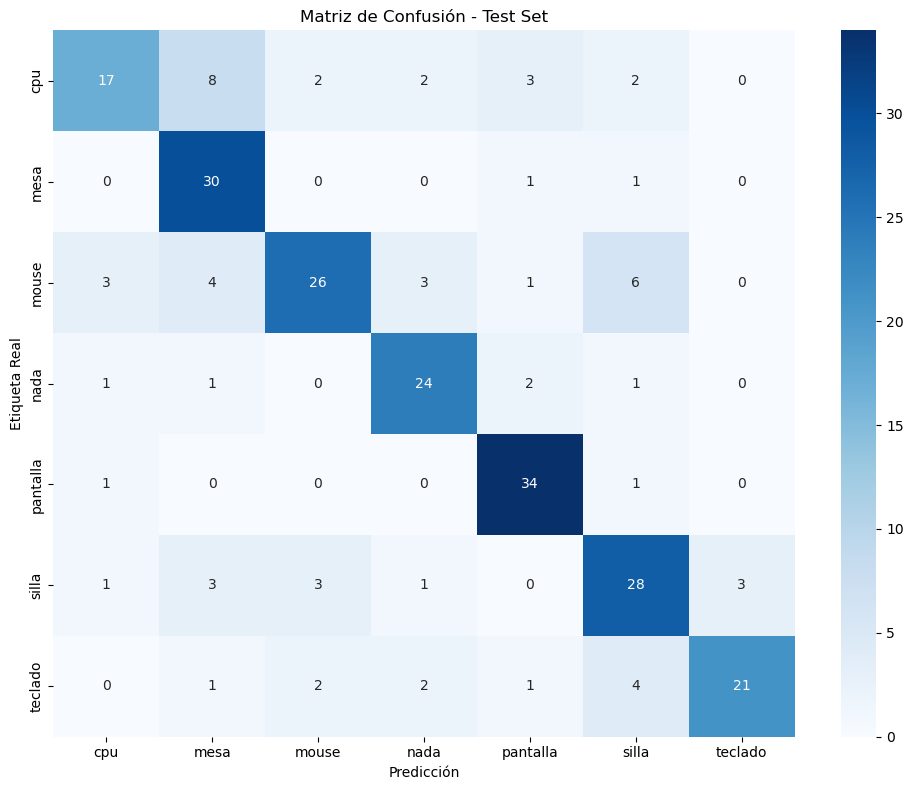

In [19]:
# Evaluar en test set
test_acc, test_preds, test_labels, test_probs = evaluate_classifier(classifier, test_loader, classes)

## 8. Sistema robusto de guardado de modelos

In [20]:
def save_complete_model(autoencoder, classifier, config, classes, history, export_dir='export_v4'):
    """
    Guarda todo lo necesario para usar el modelo en producción.
    """
    os.makedirs(export_dir, exist_ok=True)
    
    # 1. Guardar pesos del autoencoder
    torch.save(autoencoder.state_dict(), f"{export_dir}/autoencoder_state.pt")
    print(f"✓ Autoencoder guardado: {export_dir}/autoencoder_state.pt")
    
    # 2. Guardar pesos del clasificador
    torch.save(classifier.state_dict(), f"{export_dir}/classifier_state.pt")
    print(f"✓ Clasificador guardado: {export_dir}/classifier_state.pt")
    
    # 3. Guardar el modelo completo (arquitectura + pesos) - BACKUP
    torch.save({
        'autoencoder': autoencoder,
        'classifier': classifier
    }, f"{export_dir}/complete_models.pt")
    print(f"✓ Modelos completos guardados: {export_dir}/complete_models.pt")
    
    # 4. Guardar metadatos CORRECTOS
    metadata = {
        'framework': 'pytorch',
        'created_at': datetime.now().isoformat(),
        
        # Información de las clases
        'classes': classes,
        'num_classes': len(classes),
        
        # Arquitectura
        'architecture': {
            'latent_dim': config['latent_dim'],
            'img_size': config['img_size'],
            'dropout': config['dropout']
        },
        
        # Transformaciones (CRÍTICO para inferencia)
        'transforms': {
            'resize': config['img_size'],
            'normalize_mean': [0.5, 0.5, 0.5],
            'normalize_std': [0.5, 0.5, 0.5]
        },
        
        # Configuración de entrenamiento
        'training': {
            'ae_epochs': config['ae_epochs'],
            'classifier_epochs': config['classifier_epochs'],
            'batch_size': config['batch_size'],
            'ae_lr': config['ae_lr'],
            'classifier_lr': config['classifier_lr']
        },
        
        # Métricas finales
        'performance': {
            'final_train_acc': history['train_acc'][-1] if history['train_acc'] else 0,
            'final_val_acc': history['val_acc'][-1] if history['val_acc'] else 0,
            'best_val_acc': max(history['val_acc']) if history['val_acc'] else 0
        },
        
        # Información del sistema
        'system': {
            'device': str(device),
            'pytorch_version': torch.__version__
        }
    }
    
    with open(f"{export_dir}/metadata.json", 'w', encoding='utf-8') as f:
        json.dump(metadata, f, indent=2, ensure_ascii=False)
    print(f"✓ Metadata guardado: {export_dir}/metadata.json")
    
    # 5. Guardar historial de entrenamiento
    with open(f"{export_dir}/training_history.json", 'w', encoding='utf-8') as f:
        json.dump(history, f, indent=2)
    print(f"✓ Historial guardado: {export_dir}/training_history.json")
    
    print(f"\n{'='*60}")
    print(f"MODELO GUARDADO EXITOSAMENTE EN: {export_dir}/")
    print(f"{'='*60}")
    print("\nArchivos creados:")
    for file in os.listdir(export_dir):
        filepath = os.path.join(export_dir, file)
        size = os.path.getsize(filepath) / 1024  # KB
        print(f"  - {file} ({size:.1f} KB)")
    
    return metadata

In [21]:
# Guardar todo
metadata = save_complete_model(
    autoencoder=autoencoder,
    classifier=classifier,
    config=CONFIG,
    classes=classes,
    history=clf_history,
    export_dir=CONFIG['export_dir']
)

✓ Autoencoder guardado: export_v4/autoencoder_state.pt
✓ Clasificador guardado: export_v4/classifier_state.pt
✓ Modelos completos guardados: export_v4/complete_models.pt
✓ Metadata guardado: export_v4/metadata.json
✓ Historial guardado: export_v4/training_history.json

MODELO GUARDADO EXITOSAMENTE EN: export_v4/

Archivos creados:
  - metadata.json (0.8 KB)
  - complete_models.pt (1449.5 KB)
  - training_history.json (2.4 KB)
  - classifier_state.pt (1442.2 KB)
  - autoencoder_state.pt (1178.2 KB)


## 9. Resumen del entrenamiento

In [22]:
print("\n" + "="*60)
print("RESUMEN FINAL")
print("="*60)
print(f"\nClases: {classes}")
print(f"Total clases: {len(classes)}")
print(f"\nAutoencoder:")
print(f"  - Latent dim: {CONFIG['latent_dim']}")
print(f"  - Mejor val loss: {min(ae_history['val_loss']):.4f}")
print(f"\nClasificador:")
print(f"  - Mejor val accuracy: {max(clf_history['val_acc']):.2f}%")
print(f"  - Test accuracy: {test_acc:.2f}%")
print(f"\nModelos guardados en: {CONFIG['export_dir']}/")
print(f"\nPróximo paso: Usar 'inference.py' para clasificar imágenes nuevas")
print("="*60)


RESUMEN FINAL

Clases: ['cpu', 'mesa', 'mouse', 'nada', 'pantalla', 'silla', 'teclado']
Total clases: 7

Autoencoder:
  - Latent dim: 128
  - Mejor val loss: 0.0491

Clasificador:
  - Mejor val accuracy: 76.45%
  - Test accuracy: 73.77%

Modelos guardados en: export_v4/

Próximo paso: Usar 'inference.py' para clasificar imágenes nuevas
